In [2]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, MaxPool2D, Flatten
import os
import matplotlib.pyplot as plt
import seaborn as sns
from keras.callbacks import ReduceLROnPlateau

2023-04-14 00:55:59.201078: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-14 00:55:59.825865: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
train = pd.read_csv('FacialData/training.zip', compression='zip')
test = pd.read_csv('FacialData/test.zip', compression='zip')
IdLookupTable = pd.read_csv('FacialData/IdLookupTable.csv')

In [4]:
train.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


In [5]:
IdLookupTable.head(5)

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN
1,2,1,left_eye_center_y,NaN
2,3,1,right_eye_center_x,NaN
3,4,1,right_eye_center_y,NaN
4,5,1,left_eye_inner_corner_x,NaN


In [6]:
test.head(5)

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [7]:
train.fillna(method = 'ffill', inplace = True)
train.isnull().sum().any()

False

In [8]:
m, n =train.shape
m

7049

In [9]:
n

31

In [10]:
np.array(train['Image'][0].split(' '), dtype='float64')

array([238., 236., 237., ...,  70.,  75.,  90.])

In [11]:
img = []
img_size = 96
for i in range(m):
    spliting = np.array(train['Image'][i].split(' '),dtype = 'float64')
    splitting = np.reshape(spliting,(img_size,img_size,1))
    splitting /= 255 
    img.append(splitting)
img = np.array(img)

In [12]:
X_train = img
train.drop('Image',axis = 1, inplace = True)
y_train = []

for i in range(len(train)):
    y = train.iloc[i,:].values
    y_train.append(y)

In [13]:
y_train= np.array(y_train, dtype = 'float')

In [14]:
print(X_train.shape,y_train.shape)

(7049, 96, 96, 1) (7049, 30)


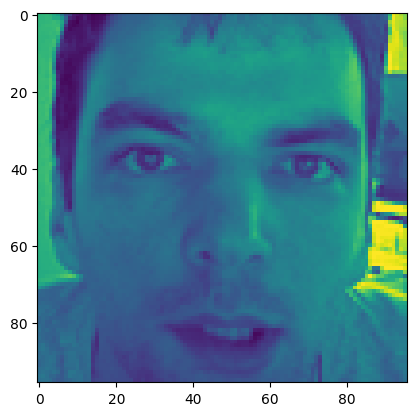

In [15]:
plt.imshow(X_train[5])

In [37]:
def image_with_keypoints(df, test_df, index):
    image = plt.imshow(df[index],cmap = 'gray')
    l = []
    for i in range(1,31,2):
        l.append(plt.plot(test_df[index][i-1], test_df[index][i],'r.'))
    return image,l

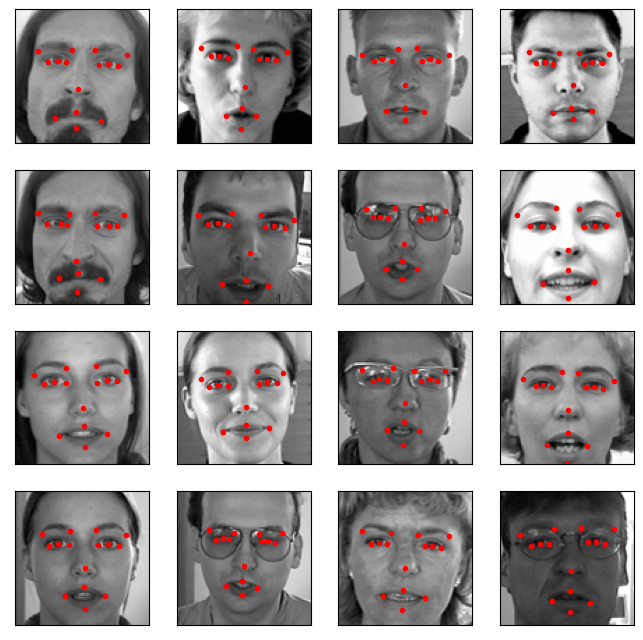

In [38]:
fig = plt.figure(figsize=(8,8))

for i in range(16):
    ax = fig.add_subplot(4,4, i+1, xticks = [], yticks = [])
    image_with_keypoints(X_train, y_train, i)
plt.show()

In [18]:
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, MaxPool2D, Flatten, BatchNormalization,Dense
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
model = Sequential()
model.add(Conv2D(128,(3,3),strides=1,activation='relu',padding = 'same',input_shape=(img_size,img_size,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
model.add(Conv2D(128,(3,3),strides=1,activation='relu',padding = 'same'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
model.add(Conv2D(64,(3,3),strides=1,activation='relu',padding = 'same'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
model.add(Conv2D(32,(3,3),strides=1,activation='relu',padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(30))
model.compile(optimizer='Adam',loss = 'mae',metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 128)       1280      
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 128)      512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 128)       147584    
                                                                 
 dropout (Dropout)           (None, 48, 48, 128)       0         
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 128)      5

2023-04-14 00:59:19.427204: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [20]:
history = model.fit(X_train,y_train,batch_size=32,epochs=40, validation_split=0.2)

Epoch 1/40
177/177 [==============================] - 81s 450ms/step - loss: 9.6108 - accuracy: 0.2770 - val_loss: 33.9936 - val_accuracy: 0.3206
Epoch 2/40
177/177 [==============================] - 78s 438ms/step - loss: 5.0003 - accuracy: 0.3818 - val_loss: 29.1268 - val_accuracy: 0.6149
Epoch 3/40
177/177 [==============================] - 78s 439ms/step - loss: 4.2888 - accuracy: 0.4401 - val_loss: 22.2120 - val_accuracy: 0.6333
Epoch 4/40
177/177 [==============================] - 78s 441ms/step - loss: 4.0547 - accuracy: 0.4721 - val_loss: 10.0751 - val_accuracy: 0.6660
Epoch 5/40
177/177 [==============================] - 79s 444ms/step - loss: 3.8593 - accuracy: 0.5164 - val_loss: 7.2786 - val_accuracy: 0.6879
Epoch 6/40
177/177 [==============================] - 80s 454ms/step - loss: 3.7019 - accuracy: 0.5382 - val_loss: 6.4413 - val_accuracy: 0.6865
Epoch 7/40
177/177 [==============================] - 78s 444ms/step - loss: 3.5562 - accuracy: 0.5751 - val_loss: 7.4879 - va

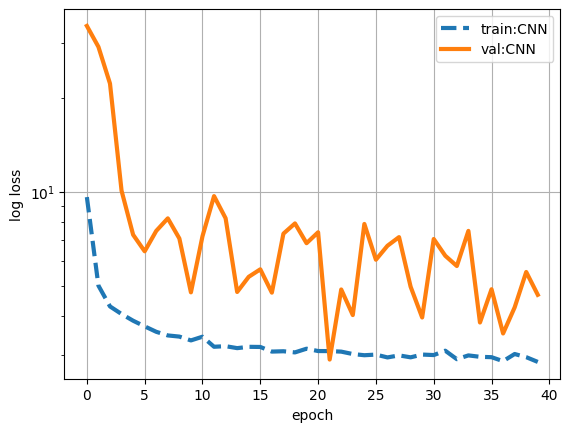

In [21]:
def plot_loss(hist,name,plt):
    '''
    RMSE_TF: if True, then RMSE is plotted with original scale 
    '''
    loss = hist['loss']
    val_loss = hist['val_loss']
    plt.plot(loss,"--",linewidth=3,label="train:"+name)
    plt.plot(val_loss,linewidth=3,label="val:"+name)

plot_loss(history.history,"CNN",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("log loss")
plt.show()

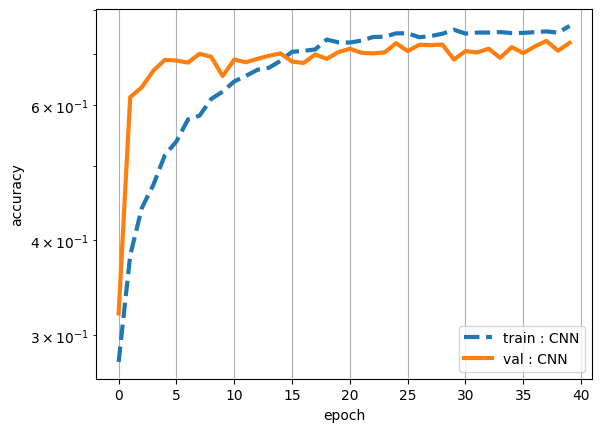

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(acc,"--",linewidth=3,label="train : CNN")
plt.plot(val_acc,linewidth=3,label="val : CNN")
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

In [23]:
test_images = []
for i in range(len(test)):
    item = np.array(test['Image'][i].split(' '), dtype='float')
    item = np.reshape(item, (img_size, img_size, 1))
    item /= 255
    test_images.append(item)
    
test_images = np.array(test_images, dtype='float')

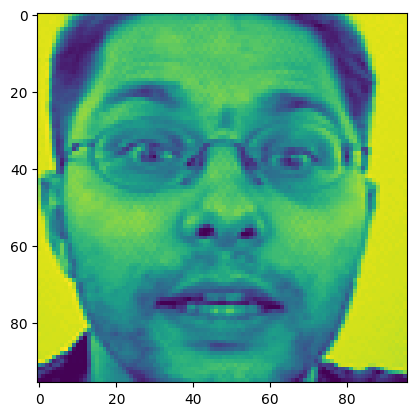

In [24]:
plt.imshow(test_images[0].reshape(96, 96))
plt.show()

In [25]:
predict = model.predict(test_images)

56/56 [==============================] - 5s 96ms/step


In [26]:
feature_names = list(IdLookupTable['FeatureName'])
image_ids = list(IdLookupTable['ImageId']-1)
row_ids = list(IdLookupTable['RowId'])

feature_list = []
for feature in feature_names:
    feature_list.append(feature_names.index(feature))

In [27]:
predictions = []
for x,y in zip(image_ids, feature_list):
    predictions.append(predict[x][y])

In [33]:
predict[x][y]

70.32523

In [34]:
predictions[:10]

[60.421482,
 33.102406,
 26.079638,
 32.48009,
 54.299488,
 34.40884,
 66.25852,
 34.62001,
 32.36742,
 33.385284]

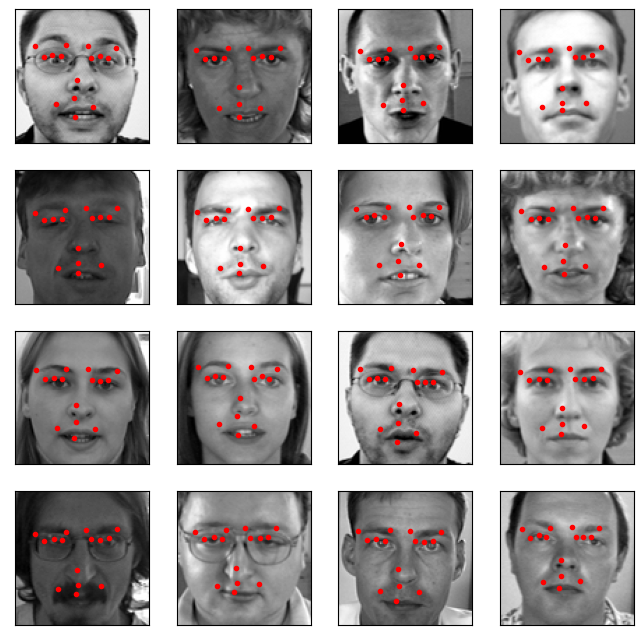

In [49]:
fig = plt.figure(figsize=(8,8))

for i in range(16):
    ax = fig.add_subplot(4,4, i+1, xticks = [], yticks = [])
    image_with_keypoints(test_images, predict, i)
plt.show()